# Project 3 – Fourier transforms and image mosaicing
Due Tuesday Nov. 7th by 12pm Points 100 Submitting a file upload

## Goals
The purpose of this assignment is to experiment with the use of the Fourier transform and to use it for image registration and filtering.  You will also build a small system that automatically creates a mosaic from a small set of overlapping input images.

### 1) FFTs
Use the built-in FFT functions in python (i.e., numpy) to compute the Fourier transform of some images and show their power spectrum.  You should organize the frequencies so that zero is in the middle of the FFT result/images.  You might need to use a log to see the power clearly.   Show results on several images and comment on what you see in both domains.  Implement a lower pass filter in the Fourier domain and do the inverse FFT to show the effects on several images.  

### 2) Phase Correlation
Implement a Fourier-based routine that computes the phase correlation between two images of the same size. You should build this function yourself using FFTs from numpy and/or SkImage.  This routine should return the result of the phase correlation in the spatial domain. I.e., for images f and g, the phase correlation is

$$p(x,y)=\mathbb{F}^{-1}\Bigg[\frac{F^{*}(u,v) \cdot G(u,v)}{|F^{*}(u,v) \cdot G(u,v)|}\Bigg]$$

In practice, you will need to extend your phase correlation to remove high-frequency components and noise. Thus, you will need a routine that computes

Phase correlation with filtering

$$p(x,y)=\mathbb{F}^{-1}\Bigg[H(u,v)\frac{F^{*}(u,v) \cdot G(u,v)}{|F^{*}(u,v) \cdot G(u,v)|}\Bigg]$$

where H is a low-pass transform/filter. Make a separate routine that builds H.

### 3) Peak Finding
If you work by transforming back to the spatial domain, you will need to find the peak in the phase correlation. For starters, you can simply look for the pixel location with maximal value. You will need to make some decisions. For instance, if the maximum value is below some threshold, you would say that two images do not overlap. For more advanced analysis, you would look for connected components in the correlation image above some threshold and do some averaging of magnitude and position within those components in order to find the best "peak'' to associate with the offset of the two images. Think about what would work best, come up with your own design, test it, and describe it in the report.  Test this part of your system and verify it works.

### 4) Mosaic Building
You should build a routine that reads in a set of images (specified in a file) and builds and saves a mosaic. You can, perhaps, assume that the first image defines the target. You will need to make a canvas and resample all images onto the canvas. Don't worry about blending, etc., for now. Just build the mosaic using whatever scheme you want between the overlapping images and evaluate the effectiveness. To compute the phase correlation between two images, they need to be the same size. Thus, you will need to preprocess images by appending rows/columns so that they all have the size of the max row and column among all the images. I suggest padding with the average image value, possibly by repeating the edge pixels or putting noise around the border. To make things simple, you should pad on the right edge and bottom, keeping the origin of the image in place.

Because phase correlation in the image domain allows for wrap-around, there is an ambiguity in the meaning of a phase correlation peak. There are two strategies to solve this. One strategy is to pad the image to be more than twice as big as the inputs in every direction. If you get more than half the padded image, you know that these result from the wrap-around of the image in that direction.

Another approach is to pad as needed for the FFT and then resolve the four cases of ambiguity after you find the peek. To do this, you would set up four separate loops to compute the correlation on the overlapping patches in the spatial domain, as shown in the figure below.

Mosaic possible configuration

Also, see the slides from class:  mosaicing_slides.  

## Experiments
You should experiment with the set of six images given here: cell_images Download cell_images. You must also build a toy example to debug with. To do this, you can take a simple image of anything (should be a good size) and manually (using an image editing tool) or write code to break it into a couple of overlapping pieces. Experiment with different thresholds and different low-pass filters or parameters.

## Code
You should not implement an FFT from scratch. In numpy, there is an fft2 function.  For this part of the project, you should need only the image I/O and display libraries and numpy.  If you choose to fit a linear function in the Fourier domain, you may use sklearn.

### 5) Extra Credit (up to 25 points) – Neural Networks for Image Translation
Design, implement, train, and test a neural network that estimates the relative offset (shift) between pairs of images.  

Model Architecture for Image Registration looks like the one below.

Neural network design

For the backbone, you can use the Pretrained model ResNet18 already provided in the Pytroch models. You can use other pre-trained models as well, like Alexnet, ResNet34, ResNet50, etc. Refer to the link below:-

https://pytorch.org/vision/stable/models.html

These models are trained for classification on ImageNet Dataset, but pre-trained trained layers of these networks provide a good starting point for the network for different applications such as instance segmentation, registration, etc.

a)  You have to use features that are observed at layer3 in the Resnet18 model for concatenation. (Note:- You don't have to use 2 backbones, a single backbone should work)

b)  Regression network Architecture is similar to the Classification network shared in the PyTorch tutorial; instead of 10 output for MNIST, the output will be just 2. However, the model will require more convolutions, max pool layers, and fully connected layers. You will also need to use BatchNorm2d in the Regression Network.

Code Given:-
extract_patched_training.py:- Creates the training set extract_patched_testing.py:- Creates the testing set utils.py:- DatasetLoader for the exercise.  Find the code here Download here.

The structure of the code will be similar to the denoising project. There will be changes in the training and testing loops to handle 4 inputs(2 images, x-shift, and y-shift) rather than 2. The model will be given 2 images compared to 1 in the denoising problem.

For visualizations, whether the predicted x and y shifts are correct or not, you will need to use the warp function provided in the skimage library or resample images with the shift in coordinates.

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import skimage
from collections import Counter
import matplotlib
from itertools import combinations
import os
from PIL import Image, ImageDraw

image_dir = os.path.join(os.path.abspath(""), '../images/*.*')
image_paths = glob.glob(image_dir)
image_paths.sort()
cell_image_paths = glob.glob(os.path.join(os.path.abspath(""), '../images/cell_images/*.png'))
cell_image_paths.sort()
image_paths, cell_image_paths

(['/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/IMG_3530.JPG',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/airplane.jpg',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/houndog1.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/me_and_blu.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/output.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/three-class-test.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/turkeys.tif',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/xray.png'],
 ['/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/cell_images/0001.000.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebooks/../images/cell_images/0001.001.png',
  '/Users/terrycox/UofUCode/ImageProcessing/Assignment3/notebo

In [25]:
def rgb_to_grey(file, weights=np.array([0.2989, 0.5870, 0.1140])):
    """Loads image and transforms to grey scale 2-D image.

    Args:
        file (str): Image file (png, tiff, jpeg, or whatever file matplotlib.pyplot.imread can read)
        weights (np.array): A vector of length 3 convert 3D image to 2D. Default is standard weights for grayscale conversion np.array([0.2989, 0.5870, 0.1140])

    Returns:
        np.array, np.array: 2D numpy array
    """
    img = plt.imread(file) # reads image to narray
    img = (img-np.min(img))
    img = img/np.max(img)
    #print(file, img.shape) # prints file and shape
    if len(img.shape) == 3: # checks to see if there image is 3D 
        if img.shape[-1] > 3: # if there are more bands than rgb, choose just the rgb matricies
            img = img[:,:,:3]
        return img @ weights # dot product weights
    else:
        return img # return image if only 2D

## 1) FFTs
Use the built-in FFT functions in python (i.e., numpy) to compute the Fourier transform of some images and show their power spectrum.  You should organize the frequencies so that zero is in the middle of the FFT result/images.  You might need to use a log to see the power clearly.   Show results on several images and comment on what you see in both domains.  Implement a lower pass filter in the Fourier domain and do the inverse FFT to show the effects on several images.  

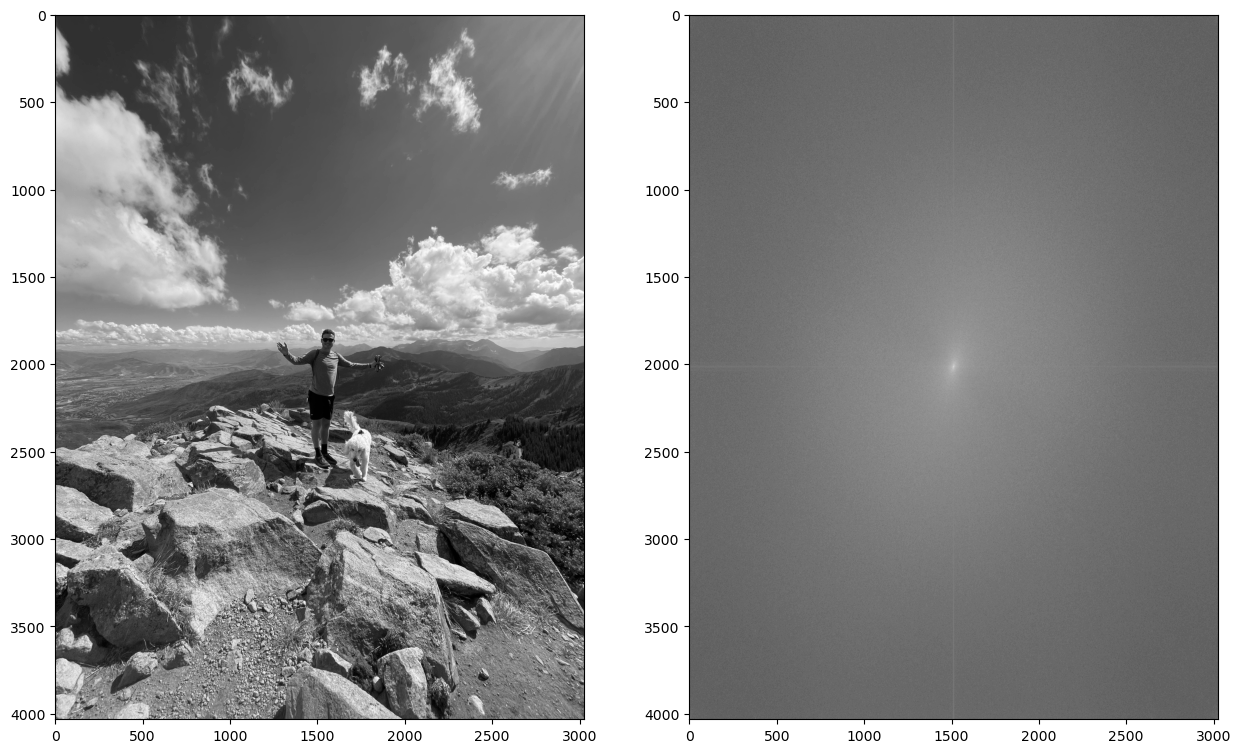

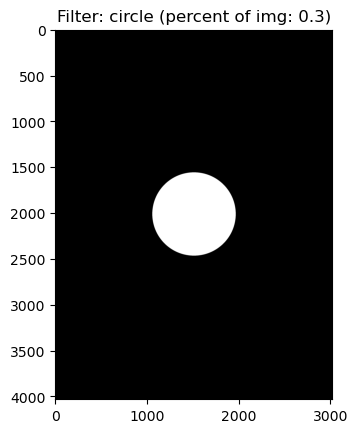

(4032, 3024) (4032, 3024)


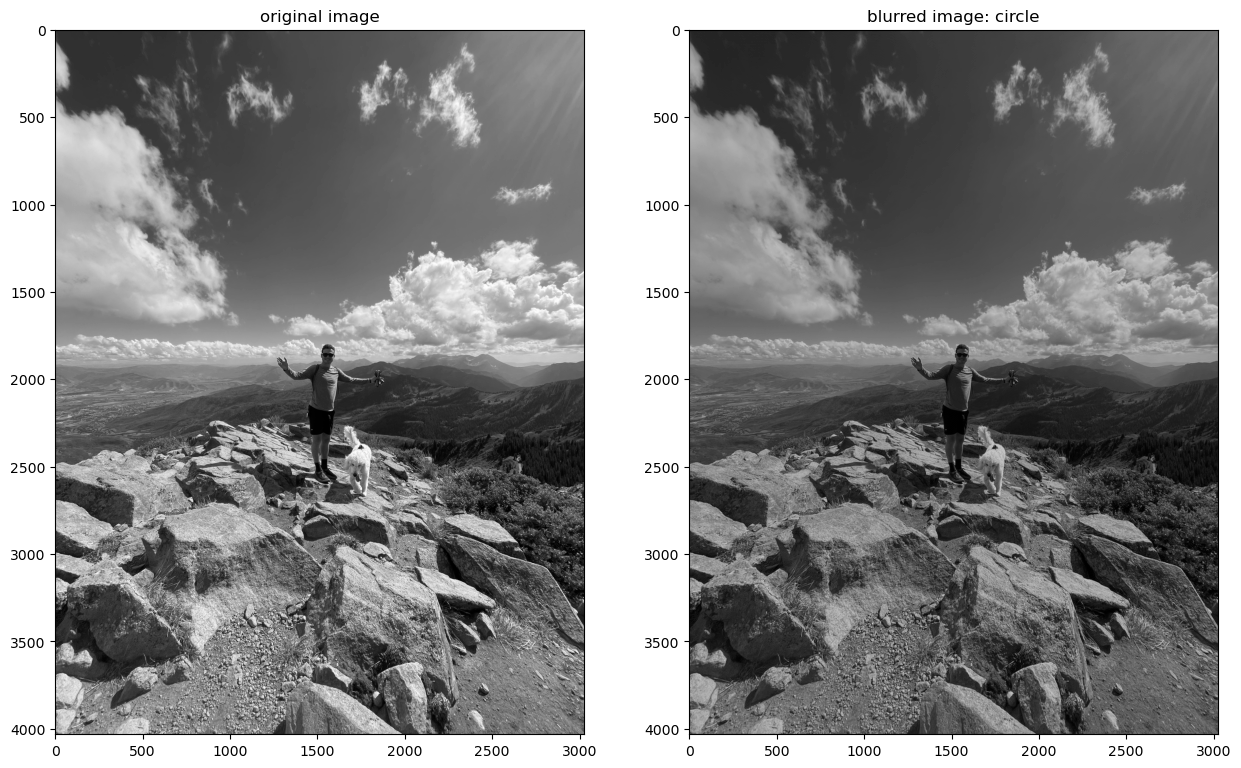

In [72]:
img_file = image_paths[-5]
img = rgb_to_grey(img_file)

fourier_image = np.fft.fft2(img)

#ft = np.fft.ifftshift(img)
ft = np.fft.fft2(img)
fourier_image = np.fft.fftshift(ft)

fourier_amplitudes = np.abs(fourier_image)**2

figsize = (15,10) if img.shape[0] > img.shape[1] else (10,15)

shape = (1,2)
f, axarr = plt.subplots(1,2, figsize=figsize)
axarr[0].imshow(img, cmap='gray')
axarr[1].imshow(np.log(fourier_amplitudes), cmap='gray')
plt.show()

def gaussian_filter(sigma, img):
    # SOME CODE FROM https://medium.com/@akumar5/computer-vision-gaussian-filter-from-scratch-b485837b6e09
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_filter[x+m, y+n] = (1/x1)*x2
    filter = np.zeros(img.shape, np.float32)
    x = (filter.shape[0] - filter_size)//2
    y = (filter.shape[1] - filter_size)//2
    filter[x:x+filter_size, y:y+filter_size] = gaussian_filter
    return filter

def circle_filter(img, percent_of_img=0.2):
    # SOME CODE FROM https://stackoverflow.com/questions/54641616/low-pass-filter-for-blurring-an-image
    #Create a low pass filter image
    x,y = img.shape[0],img.shape[1]
    #size of circle
    e_x,e_y=int(np.min(img.shape)*percent_of_img), int(np.min(img.shape)*percent_of_img)
    #create a box 
    bbox=((x/2)-(e_x/2),(y/2)-(e_y/2),(x/2)+(e_x/2),(y/2)+(e_y/2))

    low_pass=Image.new("L",(img.shape[0],img.shape[1]),color=0)

    draw1=ImageDraw.Draw(low_pass)
    draw1.ellipse(bbox, fill=1)
    
    low_pass = np.array(low_pass).T
    return low_pass

percent_of_img=0.05

def low_pass_filter(img, percent_of_img=0.05, lpf_type='gaussian', show_image=True):
    ft = np.fft.fft2(img)
    fourier_image = np.fft.fftshift(ft)

    if lpf_type == 'gaussian':
        sigma = int(np.min(img.shape)*percent_of_img)
        low_pass = gaussian_filter(sigma=sigma, img=img)
    else:
        low_pass = circle_filter(img=img, percent_of_img=percent_of_img)

    low_pass_np=np.array(low_pass)
    if show_image:
        plt.imshow(low_pass_np, cmap='gray')
        plt.title('Filter: '+lpf_type+f' (percent of img: {percent_of_img})')
        plt.show()

    print(low_pass_np.shape, fourier_image.shape)
    #multiply both the images
    filtered=np.multiply(fourier_image,low_pass_np)


    #inverse fft
    ifft2 = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
    ifft2 = np.maximum(0, np.minimum(ifft2, 255))

    if show_image:
        shape = (1,2)
        f, axarr = plt.subplots(1,2, figsize=figsize)
        axarr[0].imshow(img, cmap='gray')
        axarr[0].set_title('original image')
        axarr[1].imshow(ifft2, cmap='gray')
        axarr[1].set_title('blurred image: '+lpf_type)
        plt.show()

    return ifft2

ifft2 = low_pass_filter(img, percent_of_img=0.3, lpf_type='circle')

## 2) Phase Correlation
Implement a Fourier-based routine that computes the phase correlation between two images of the same size. You should build this function yourself using FFTs from numpy and/or SkImage.  This routine should return the result of the phase correlation in the spatial domain. I.e., for images f and g, the phase correlation is

$$p(x,y)=\mathbb{F}^{-1}\Bigg[\frac{F^{*}(u,v) \cdot G(u,v)}{|F^{*}(u,v) \cdot G(u,v)|}\Bigg]$$

In practice, you will need to extend your phase correlation to remove high-frequency components and noise. Thus, you will need a routine that computes

Phase correlation with filtering

$$p(x,y)=\mathbb{F}^{-1}\Bigg[H(u,v)\frac{F^{*}(u,v) \cdot G(u,v)}{|F^{*}(u,v) \cdot G(u,v)|}\Bigg]$$

where H is a low-pass transform/filter. Make a separate routine that builds H.

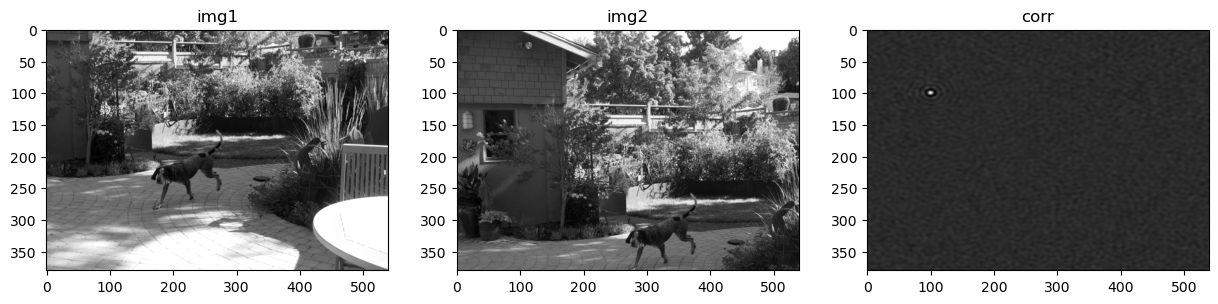

(100, 100)

In [287]:

def get_2_images_4_corr(img, shift = 50):
    size = img.shape
    return img[shift:size[0], shift:size[1]], img[:size[0]-shift, :size[1]-shift] 

def phase_correlation(img1, img2, H=None):
    ft1 = np.fft.fft2(img1)
    four1 = np.fft.fftshift(ft1)

    ft2 = np.fft.fft2(img2)
    four2 = np.fft.fftshift(ft2)

    conj_ft1 = np.conjugate(four1)

    #numerator = np.multiply(conj_ft1, four2)
    numerator = np.multiply(conj_ft1, four2)
    denominator = np.abs(numerator)
    F_corr = np.divide(numerator,denominator)
    if H is not None:
        F_corr = np.multiply(H, F_corr)

    corr = np.real(np.fft.ifft2(np.fft.ifftshift(F_corr)))
    #corr[corr < 0] = 0
    return corr


img_file = image_paths[2]
img = rgb_to_grey(img_file)



img1, img2 = get_2_images_4_corr(img, shift = 100)
lp_filter = circle_filter(img=img1, percent_of_img=0.3)

corr = phase_correlation(img1=img1, img2=img2, H=lp_filter)

def plt_corr(img1, img2, corr):
    f, axarr = plt.subplots(1,3, figsize=(15,20))
    axarr[0].imshow(img1, cmap='gray')
    axarr[0].set_title('img1')
    axarr[1].imshow(img2, cmap='gray')
    axarr[1].set_title('img2')
    axarr[2].imshow(corr, cmap='gray')
    axarr[2].set_title('corr')
    plt.show()
plt_corr(img1, img2, corr)

peak = np.unravel_index(corr.argmax(), corr.shape)
peak

In [289]:
img_shape = img1.shape

# up_inv_left_inv_1 = img1[x_inv:, img_shape[1]-peak[1]:]
# up_inv_left_inv_2 = img2[:peak[0], :peak[1]]

# down_inv_right_inv_1 = img1[:peak[0], :peak[1]]
# down_inv_right_inv_2 = img2[x_inv:, img_shape[1]-peak[1]:]

# up_inv_right_inv_1 = img1[img_shape[0]-peak[0]:, :peak[1]]
# up_inv_right_inv_2 = img2[:peak[0], img_shape[1]-peak[1]:]

# down_inv_left_inv_1 = img1[:peak[0], img_shape[1]-peak[1]:]
# down_inv_left_inv_2 = img2[img_shape[0]-peak[0]:, :peak[1]]


# up_left_inv_1 = img1[peak[0]:, img_shape[1]-peak[1]:]
# up_left_inv_2 = img2[:img_shape[0]-peak[0], :peak[1]]

# down_right_inv_1 = img1[:img_shape[0]-peak[0], :peak[1]]
# down_right_inv_2 = img2[peak[0]:, img_shape[1]-peak[1]:]

# up_right_inv_1 = img1[peak[0]:, :peak[1]]
# up_right_inv_2 = img2[:img_shape[0]-peak[0], img_shape[1]-peak[1]:]

# down_left_inv_1 = img1[:img_shape[0]-peak[0], img_shape[1]-peak[1]:]
# down_left_inv_2 = img2[peak[0]:, :peak[1]]


# up_left_1 = img1[peak[0]:, peak[1]:]
# up_left_2 = img2[:img_shape[0]-peak[0], :img_shape[1]-peak[1]]

# down_right_1 = img1[:img_shape[0]-peak[0], :img_shape[1]-peak[1]]
# down_right_2 = img2[peak[0]:, peak[1]:]

# up_right_1 = img1[peak[0]:, :img_shape[1]-peak[1]]
# up_right_2 = img2[:img_shape[0]-peak[0], peak[1]:]

# down_left_1 = img1[:img_shape[0]-peak[0], peak[1]:]
# down_left_2 = img2[peak[0]:, :img_shape[1]-peak[1]]


# up_inv_left_1 = img1[img_shape[0]-peak[0]:, peak[1]:]
# up_inv_left_2 = img2[:peak[0], :img_shape[1]-peak[1]]

# down_inv_right_1 = img1[:peak[0], :img_shape[1]-peak[1]]
# down_inv_right_2 = img2[img_shape[0]-peak[0]:, peak[1]:]

# up_inv_right_1 = img1[img_shape[0]-peak[0]:, :img_shape[1]-peak[1]]
# up_inv_right_2 = img2[:peak[0], peak[1]:]

# down_inv_left_1 = img1[:peak[0], peak[1]:]
# down_inv_left_2 = img2[img_shape[0]-peak[0]:, :img_shape[1]-peak[1]]

direct_corr_dict = {}

# def four_possibilities(img1, img2, x, y, x_inv, y_inv):
#     dirct_corr_dict_loc = {}
#     try:
#         dirct_corr_dict_loc[(x_inv, y_inv)] = {
#                 'img1' : img1[x_inv:, y_inv:],
#                 'img2' : img2[:x, :y]
#         }
#     except:
#         pass
#     try:
#         dirct_corr_dict_loc[(-x, y_inv)] = {
#                 'img1' : img1[:x_inv, y_inv:],
#                 'img2' : img2[x:, :y]
#         }
#     except:
#         pass

#     try:
#         dirct_corr_dict_loc[(-x, -y)] = {
#                 'img1' : img1[x:, :y_inv],
#                 'img2' : img2[x:, y:]
#         }
#     except:
#         pass
    
#     try:
#         dirct_corr_dict_loc[(x_inv, -y)] = {
#                 'img1' : img1[x_inv:, :y_inv],
#                 'img2' : img2[:x, y:]
#         }
#     except:
#         pass
    
#     return dirct_corr_dict_loc


def built_direct_corr_dict_loc(img1, img2, a, b, c, d):
    dirct_corr_dict_loc = {}
    try:
        dirct_corr_dict_loc[(a, b)] = {
                'img1' : img1[a:, b:],
                'img2' : img2[:c, :d]
        }
    except:
        pass
    try:
        dirct_corr_dict_loc[(-a, -b)] = {
                'img1' : img1[:c, :d],
                'img2' : img2[a:, b:]
        }
    except:
        pass

    try:
        dirct_corr_dict_loc[(a, -b)] = {
                'img1' : img1[a:, :d],
                'img2' : img2[:c, b:]
        }
    except:
        pass
    
    try:
        dirct_corr_dict_loc[(-a, b)] = {
                'img1' : img1[:c, b:],
                'img2' : img2[a:, :d]
        }
    except:
        pass
    
    return dirct_corr_dict_loc

def built_direct_corr_dict(img1, img2, peak):
    dirct_corr_dict = {}
    img_size = img1.shape
    x = peak[0]
    y = peak[1]
    x_inv = img_size[0]-peak[0]
    y_inv = img_size[1]-peak[1]

    dirct_corr_dict = {**dirct_corr_dict, **built_direct_corr_dict_loc(img1, img2, x, y, x_inv, y_inv)}
    dirct_corr_dict = {**dirct_corr_dict, **built_direct_corr_dict_loc(img1, img2, x_inv, y_inv, x, y)}
    dirct_corr_dict = {**dirct_corr_dict, **built_direct_corr_dict_loc(img1, img2, x, y_inv, x_inv, y)}
    dirct_corr_dict = {**dirct_corr_dict, **built_direct_corr_dict_loc(img1, img2, x_inv, y, x, y_inv)}
    
    return dirct_corr_dict

def mse(X,Y):
    return np.mean((X-Y)**2)

def find_direction(img1, img2, peak):
    direct_corr_dict = built_direct_corr_dict(img1, img2, peak)
    min_ = np.inf
    dirct = None
    for k, v in direct_corr_dict.items():
        direct_corr_dict[k]['mse'] = mse(v['img1'], v['img2'])
        if direct_corr_dict[k]['mse'] < min_:
            min_ = direct_corr_dict[k]['mse']
            dirct = k

    return dirct, direct_corr_dict


direction, test = find_direction(img1, img2, peak)
direction


(-100, -100)

## 3) Peak Finding
If you work by transforming back to the spatial domain, you will need to find the peak in the phase correlation. For starters, you can simply look for the pixel location with maximal value. You will need to make some decisions. For instance, if the maximum value is below some threshold, you would say that two images do not overlap. For more advanced analysis, you would look for connected components in the correlation image above some threshold and do some averaging of magnitude and position within those components in order to find the best "peak'' to associate with the offset of the two images. Think about what would work best, come up with your own design, test it, and describe it in the report.  Test this part of your system and verify it works.

In [234]:
def peak_finder(corr, method='max', thresh=None, n_stds=3, verbose=False):
    if method=='max':
        if verbose:
            print('Max:', np.max(corr))
        return np.unravel_index(corr.argmax(), corr.shape)
    elif method == 'thresh':
        if verbose:
            print('thresh:', thresh)
        if np.max(corr) > thresh:
            return peak_finder(corr=corr, method='max', verbose=verbose)
        else:
            return False
    elif method=='variance':
        mean = np.mean(corr)
        std = np.std(corr)
        if verbose:
            print('mean:', mean, 'std:', std)
        z = mean + n_stds*std
        return peak_finder(corr=corr, method='thresh', thresh=z, verbose=verbose)
    elif method=='min_var':
        mean = np.mean(corr)
        std = np.std(corr)
        if verbose:
            print('mean:', mean, 'std:', std)
        n_stds = (np.min(corr)-mean)/std
        z = mean - 2*n_stds*std
        return peak_finder(corr=corr, method='thresh', thresh=z, verbose=verbose)
    else:
        print("method must be: max, thresh, or variance")

peak_finder(corr=corr, method='min_var', n_stds=3, verbose=True)

mean: 4.873294346978557e-06 std: 0.0004961195552680083
thresh: 0.010316391681785282
Max: 0.025971750692895205


(100, 100)

mean: 3.84467512495194e-06 std: 0.0005227980696206635
thresh: 0.005294091328352505
Max: 0.014869312242926262
direction: (376, -2)


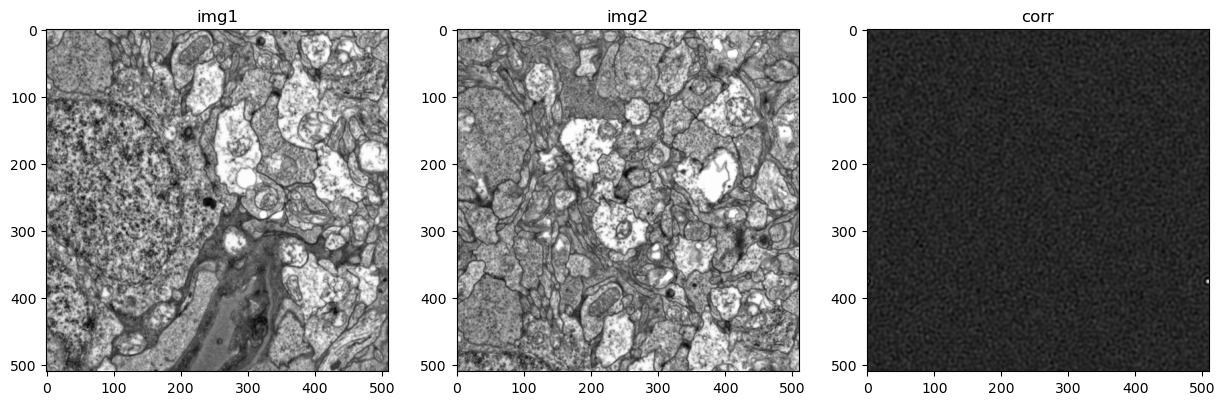

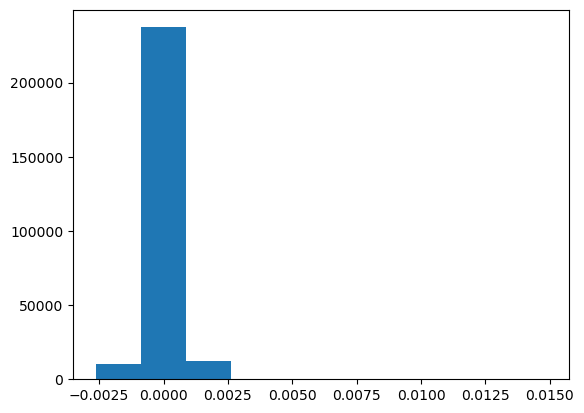

mean: 3.844675124951939e-06 std: 0.0005227980696206635
thresh: 0.004883620859071976
mean: 3.844675124951942e-06 std: 0.0005227980696206635
thresh: 0.005780565604485666
Max: 0.0193117246136932
direction: (-6, -355)


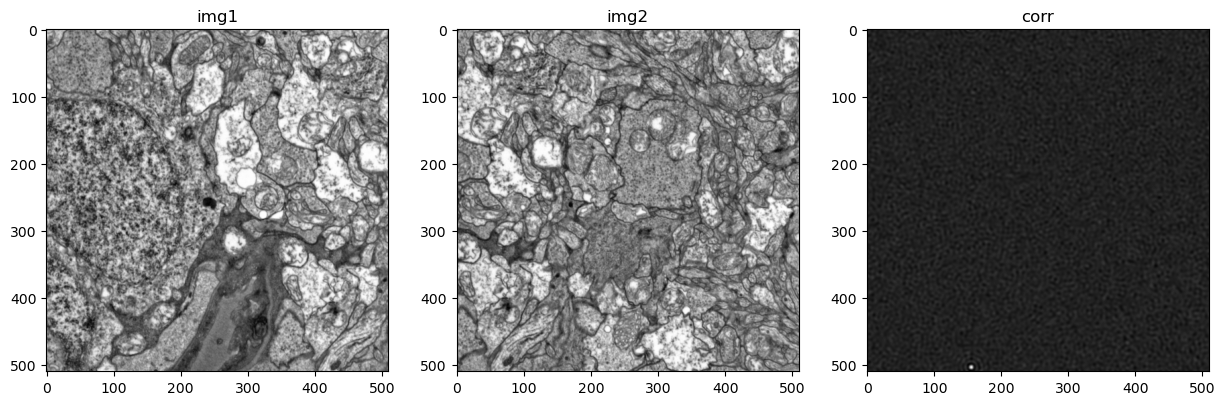

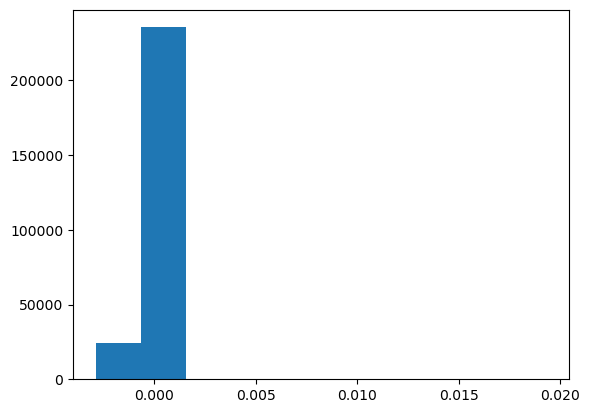

mean: 3.844675124951943e-06 std: 0.0005227980696206635
thresh: 0.004424046335409071
Max: 0.0058795344331158145
direction: (371, -362)


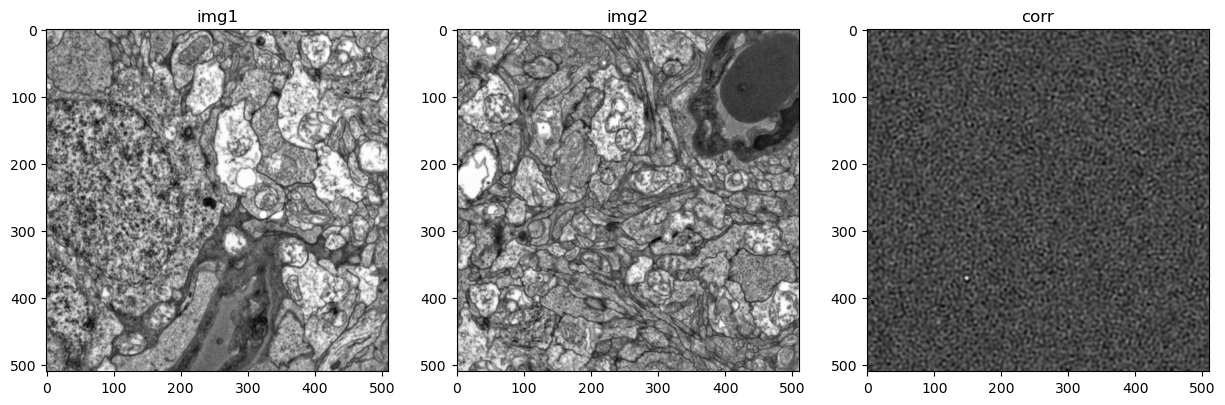

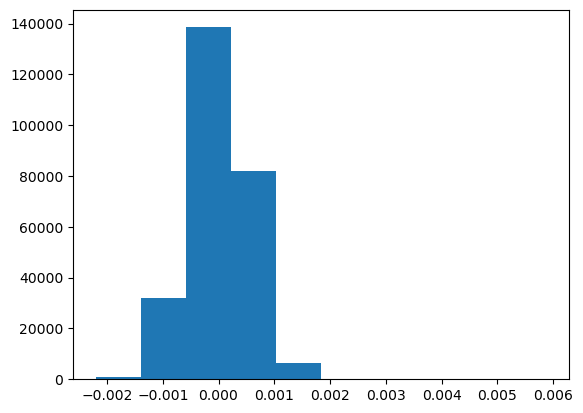

mean: 3.844675124951941e-06 std: 0.0005227980696206635
thresh: 0.004757756679255899
mean: 3.844675124951942e-06 std: 0.0005227980696206635
thresh: 0.00439505023929794
Max: 0.009398658279862937
direction: (404, 0)


/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


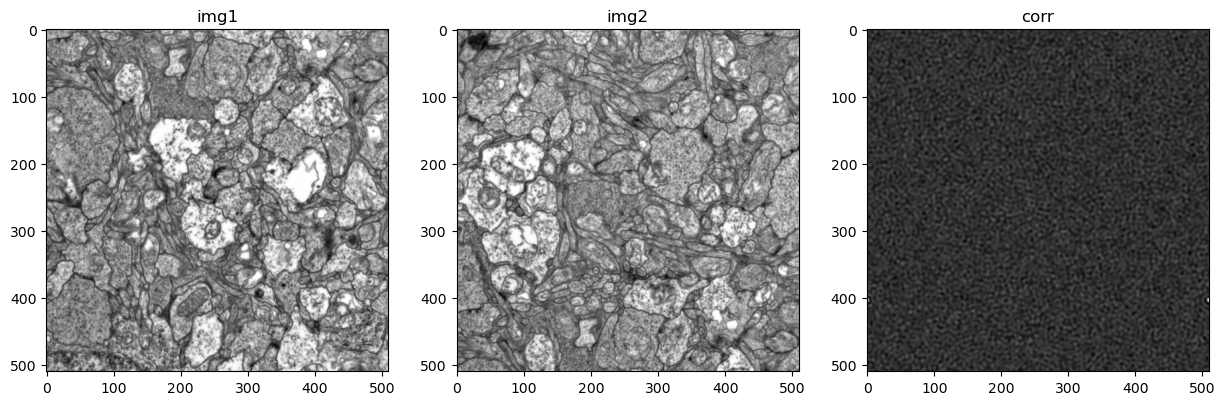

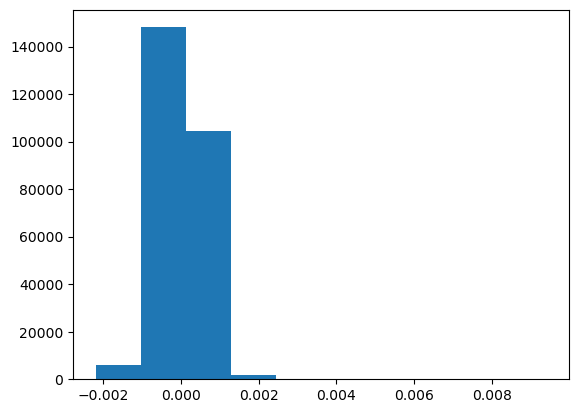

mean: 3.844675124951943e-06 std: 0.0005227980696206635
thresh: 0.004302845976624938
Max: 0.005626635101478777
direction: (-382, -354)


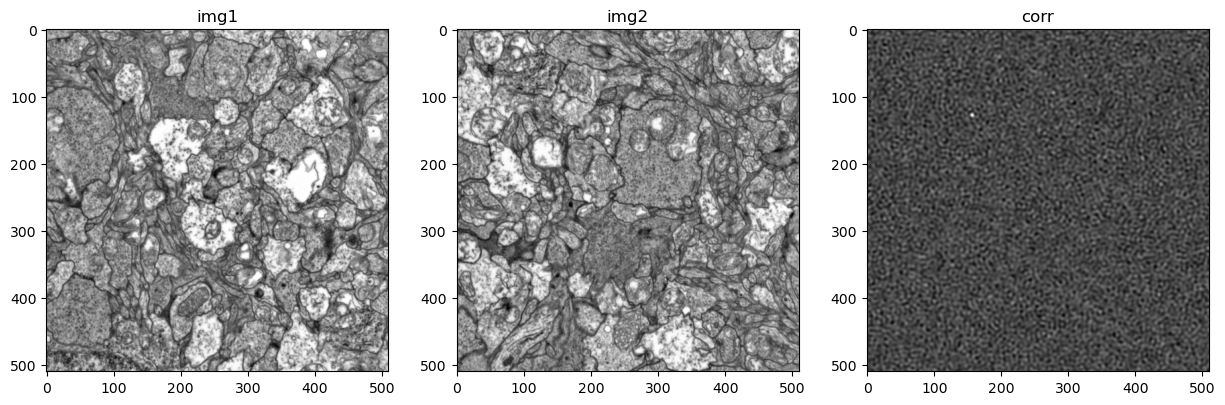

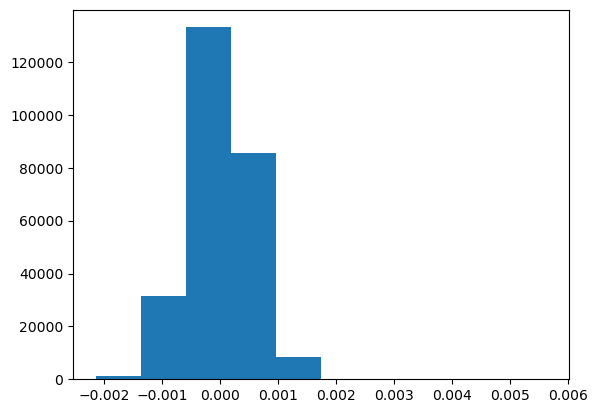

mean: 3.844675124951942e-06 std: 0.0005227980696206636
thresh: 0.006474872850204597
Max: 0.017897384195397655
direction: (-5, -360)


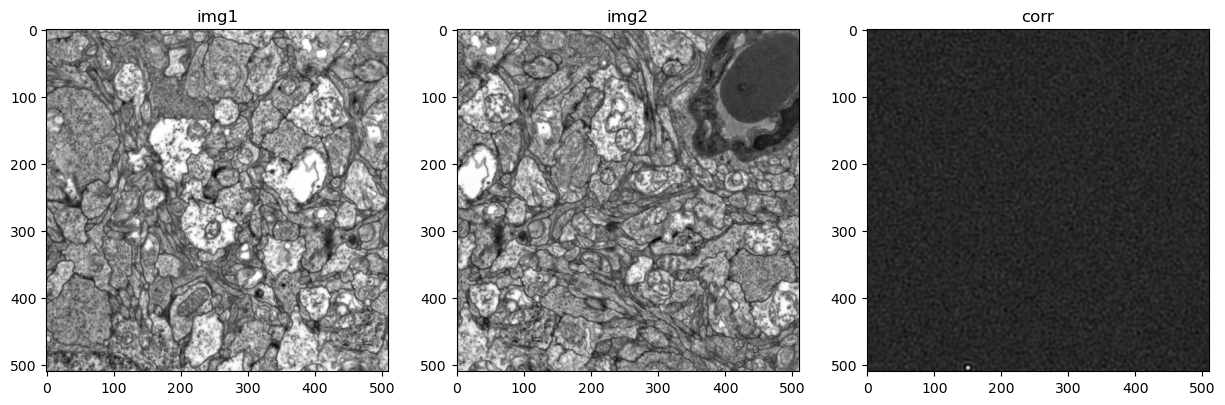

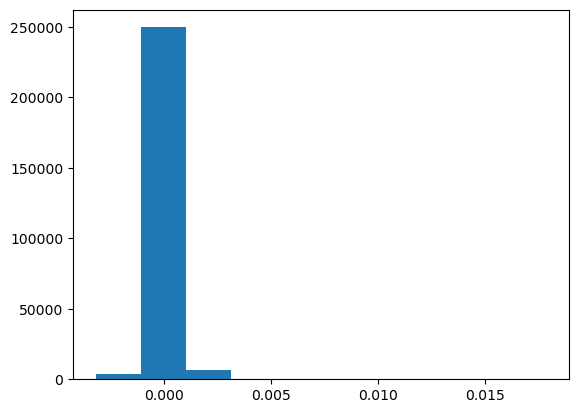

mean: 3.844675124951941e-06 std: 0.0005227980696206635
thresh: 0.0048905936731225815
mean: 3.844675124951943e-06 std: 0.0005227980696206636
thresh: 0.004638568702237754
mean: 3.844675124951942e-06 std: 0.0005227980696206636
thresh: 0.004918837675918941
mean: 3.844675124951941e-06 std: 0.0005227980696206635
thresh: 0.005408203343974271
Max: 0.01589350137108896
direction: (-5, -362)


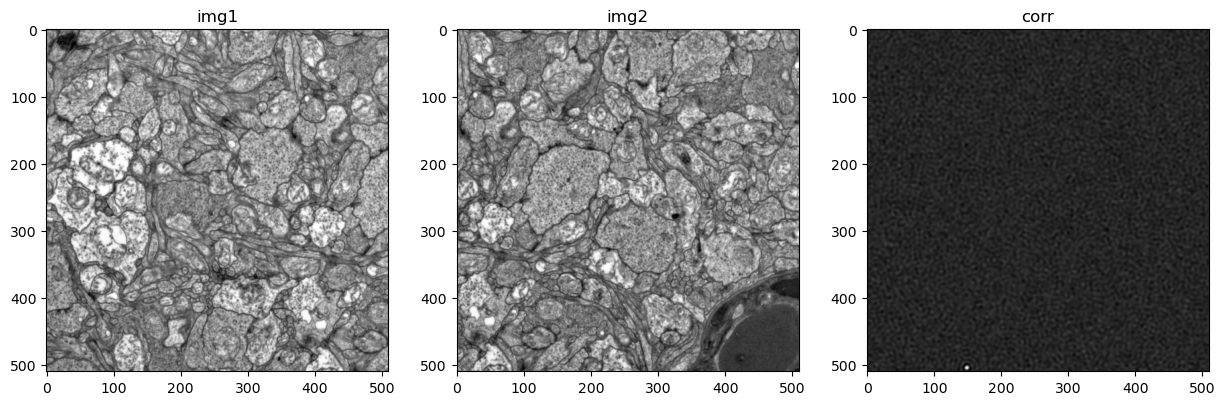

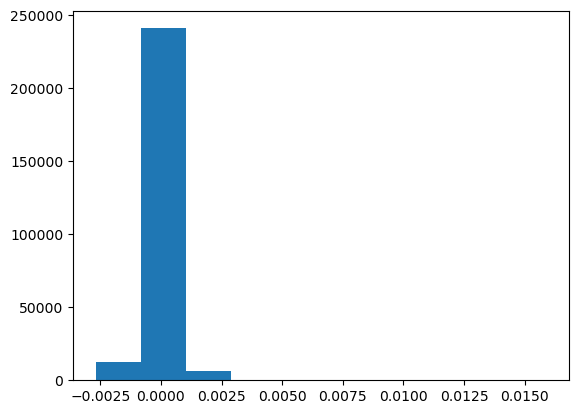

mean: 3.844675124951943e-06 std: 0.0005227980696206636
thresh: 0.006510309171477784
Max: 0.015420152174837954
direction: (377, -7)


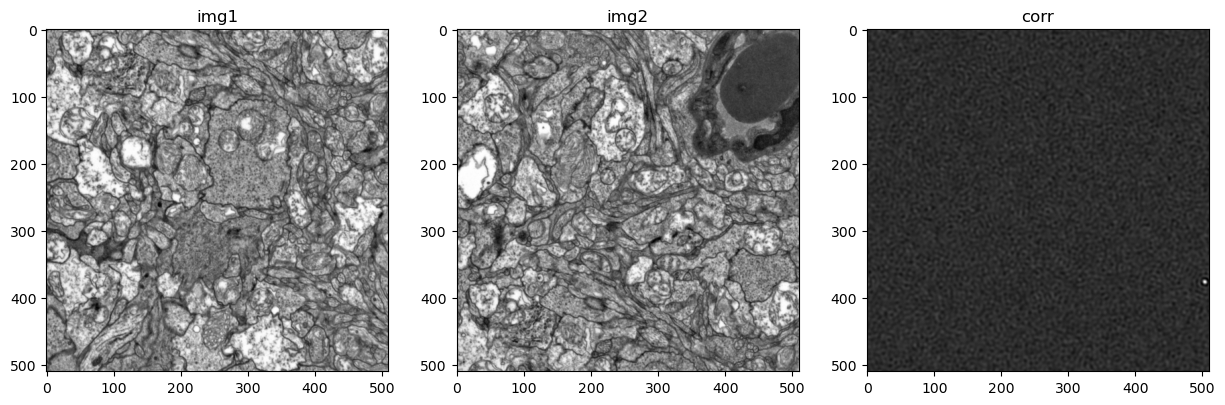

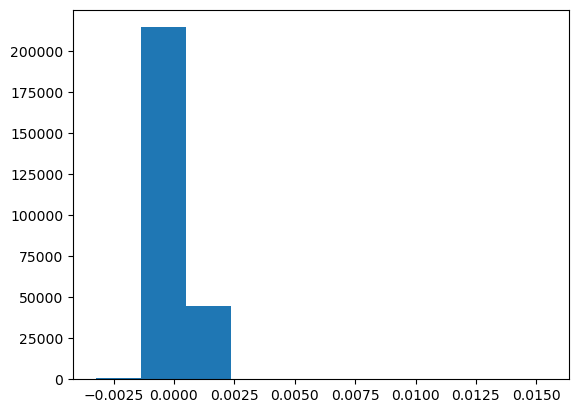

mean: 3.844675124951939e-06 std: 0.0005227980696206635
thresh: 0.004918479429566981
mean: 3.844675124951942e-06 std: 0.0005227980696206636
thresh: 0.004346235700349041
Max: 0.007182170937126249
direction: (403, -2)


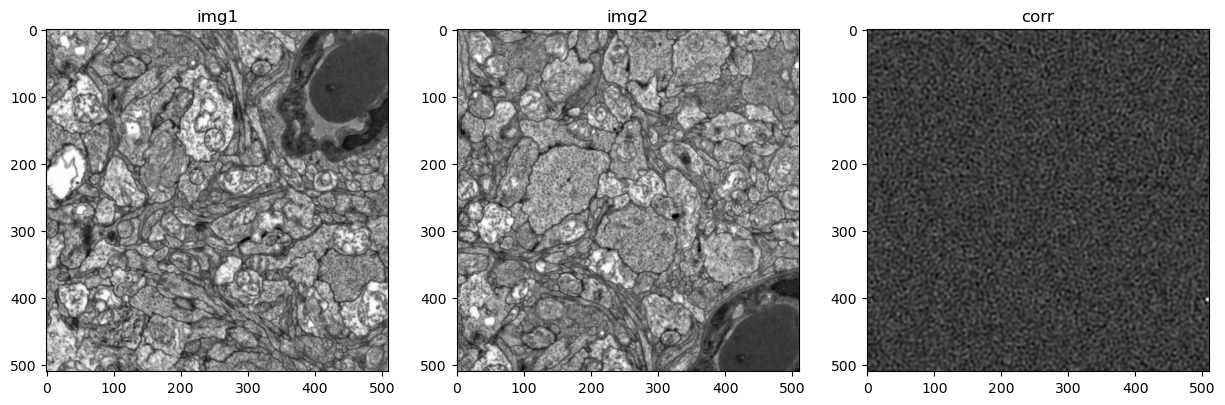

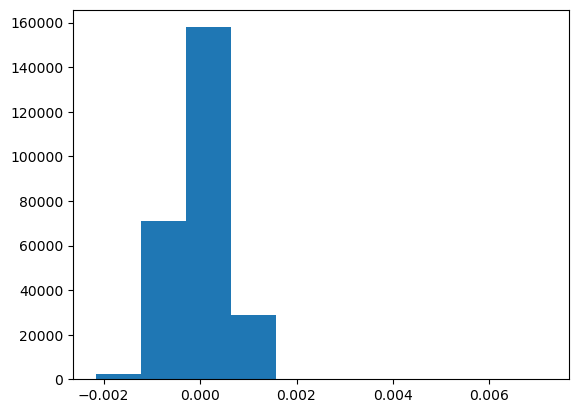

{(0, 1): (376, 508),
 (0, 2): False,
 (0, 3): (504, 155),
 (0, 4): (371, 148),
 (0, 5): False,
 (1, 2): (404, 0),
 (1, 3): (128, 156),
 (1, 4): (505, 150),
 (1, 5): False,
 (2, 3): False,
 (2, 4): False,
 (2, 5): (505, 148),
 (3, 4): (377, 503),
 (3, 5): False,
 (4, 5): (403, 508)}

In [241]:
peaks = {}
directions = {}
for i, file1 in enumerate(cell_image_paths):
    for j, file2 in enumerate(cell_image_paths):
        if i < j:
            img1 = rgb_to_grey(file1)
            img2 = rgb_to_grey(file2)

            lp_filter = circle_filter(img=img1, percent_of_img=0.3)
            corr = phase_correlation(img1=img1, img2=img2, H=lp_filter)
            peaks[(i,j)] = peak_finder(corr=corr, method='min_var', thresh=0.01, n_stds=3, verbose=True)
            
            if peaks[(i,j)]:
                direction, direct_dict = find_direction(img1, img2, peaks[(i,j)])
                directions[(i,j)] = {'direction' : direction, **direct_dict[direction]}
                print('direction:', direction)
                plt_corr(img1, img2, corr)
                plt.hist(corr.reshape(-1,1))
                plt.show()

peaks

## 4) Mosaic Building
You should build a routine that reads in a set of images (specified in a file) and builds and saves a mosaic. You can, perhaps, assume that the first image defines the target. You will need to make a canvas and resample all images onto the canvas. Don't worry about blending, etc., for now. Just build the mosaic using whatever scheme you want between the overlapping images and evaluate the effectiveness. To compute the phase correlation between two images, they need to be the same size. Thus, you will need to preprocess images by appending rows/columns so that they all have the size of the max row and column among all the images. I suggest padding with the average image value, possibly by repeating the edge pixels or putting noise around the border. To make things simple, you should pad on the right edge and bottom, keeping the origin of the image in place.

Because phase correlation in the image domain allows for wrap-around, there is an ambiguity in the meaning of a phase correlation peak. There are two strategies to solve this. One strategy is to pad the image to be more than twice as big as the inputs in every direction. If you get more than half the padded image, you know that these result from the wrap-around of the image in that direction.

Another approach is to pad as needed for the FFT and then resolve the four cases of ambiguity after you find the peek. To do this, you would set up four separate loops to compute the correlation on the overlapping patches in the spatial domain, as shown in the figure below.

Mosaic possible configuration

Also, see the slides from class:  mosaicing_slides.  

In [290]:
from collections import Counter
class Mosaic():

    def __init__(self, image_files : list) -> None:
        self.image_files = image_files
        self.images = [rgb_to_grey(file) for file in image_files]
        self.img_size = self.images[0].shape
        self.x = self.img_size[0]
        self.y = self.img_size[1]
        self.N = len(self.images)

        self.get_correlations()
        self.get_order()
        self.get_directions()

        self.canvas = np.zeros(tuple(np.array(self.img_size)*(2*self.N+1)))
        self.image_locations = {}
        pass

    def get_correlations(self, verbose=False):
        peaks = {}
        for i, img1 in enumerate(self.images):
            for j, img2 in enumerate(self.images):
                if i < j:
                    lp_filter = circle_filter(img=img1, percent_of_img=0.3)
                    corr = phase_correlation(img1=img1, img2=img2, H=lp_filter)
                    peaks[(i,j)] = peak_finder(corr=corr, method='min_var', thresh=0.01, n_stds=3, verbose=verbose)
                    if verbose and peaks[(i,j)]:
                        plt_corr(img1, img2, corr)
                        plt.hist(corr.reshape(-1,1))
                        plt.show()
        self.peaks = peaks
        return peaks

    def get_order(self):
        i_imgs = []
        for k in self.peaks.keys():
            if self.peaks[k]:
                i_imgs += list(k)
        num_i_imgs = dict(Counter(i_imgs))
        rank = [(x, num_i_imgs[x[0]]+num_i_imgs[x[1]]) for x in self.peaks.keys() if self.peaks[x]]
        rank.sort(key= lambda a : a[1], reverse=True)
        rank = {x[0] : x[1] for x in rank}
        self.img_order = list(rank.keys())
        return rank

    def built_direct_corr_dict_loc(self, img1, img2, a, b, c, d):
        '''This gets the direction of what img2 needs to move to get on img1
        '''
        dirct_corr_dict_loc = {}
        try:
            dirct_corr_dict_loc[(a, b)] = {
                    'img1' : img1[a:, b:],
                    'img2' : img2[:c, :d]
            }
        except:
            pass
        try:
            dirct_corr_dict_loc[(-a, -b)] = {
                    'img1' : img1[:c, :d],
                    'img2' : img2[a:, b:]
            }
        except:
            pass

        try:
            dirct_corr_dict_loc[(a, -b)] = {
                    'img1' : img1[a:, :d],
                    'img2' : img2[:c, b:]
            }
        except:
            pass
        
        try:
            dirct_corr_dict_loc[(-a, b)] = {
                    'img1' : img1[:c, b:],
                    'img2' : img2[a:, :d]
            }
        except:
            pass
        
        return dirct_corr_dict_loc

    def built_direct_corr_dict(self, img1, img2, peak):
        dirct_corr_dict = {}
        img_size = img1.shape
        x = peak[0]
        y = peak[1]
        x_inv = img_size[0]-peak[0]
        y_inv = img_size[1]-peak[1]

        dirct_corr_dict = {**dirct_corr_dict, **self.built_direct_corr_dict_loc(img1, img2, x, y, x_inv, y_inv)}
        dirct_corr_dict = {**dirct_corr_dict, **self.built_direct_corr_dict_loc(img1, img2, x_inv, y_inv, x, y)}
        dirct_corr_dict = {**dirct_corr_dict, **self.built_direct_corr_dict_loc(img1, img2, x, y_inv, x_inv, y)}
        dirct_corr_dict = {**dirct_corr_dict, **self.built_direct_corr_dict_loc(img1, img2, x_inv, y, x, y_inv)}
        return dirct_corr_dict

    def mse(self, X,Y):
        return np.mean((X-Y)**2)

    def find_direction(self, img1, img2, peak):
        direct_corr_dict = self.built_direct_corr_dict(img1, img2, peak)
        min_ = np.inf
        dirct = None
        for k, v in direct_corr_dict.items():
            direct_corr_dict[k]['mse'] = self.mse(v['img1'], v['img2'])
            if direct_corr_dict[k]['mse'] < min_:
                min_ = direct_corr_dict[k]['mse']
                dirct = k

        return dirct, direct_corr_dict
    
    def get_directions(self):
        self.directions = {}
        for k,v in self.peaks.items():
            if v:
                direct, direct_corr_dict = self.find_direction(img1=self.images[k[0]], img2=self.images[k[1]], peak=v)
                self.directions[k] = direct
        return self.directions

    def overlay_image(self, img, top_x, top_y):
        iss, jss = np.nonzero(self.canvas[top_x:(top_x +self.x), top_y:(top_y +self.y)])
        for i, j in zip(iss, jss):
            img[i,j] = img[i,j]/2
        self.canvas[top_x:(top_x +self.x), top_y:(top_y +self.y)] = self.canvas[top_x:(top_x +self.x), top_y:(top_y +self.y)]/2 + img


    def add_image(self, verbose=False):
        if verbose:
            print('Image Order:', self.img_order)
            print('Image Locations', self.image_locations)
        if self.img_order == []:
            return False
        
        i_imgs = self.img_order[0]
        if len(self.img_order)>1:
            self.img_order = self.img_order[1:]
        else:
            self.img_order = []

        img1 = self.images[i_imgs[0]]
        img2 = self.images[i_imgs[1]]
        direction = self.directions[i_imgs]

        if self.image_locations == {}:
            top_x = self.N*self.x
            top_y = self.N*self.y
            self.canvas[top_x:(top_x + self.x), top_y:(top_y + self.y)] = img1
            self.canvas[(top_x + direction[0]):(top_x + self.x + direction[0]), (top_y + direction[1]):(top_y + self.y + direction[1])] = img2
            #self.overlay_image(img2, top_x=top_x + direction[0], top_y=top_y + direction[1])
            self.image_locations[i_imgs[0]] = (top_x, top_y)
            self.image_locations[i_imgs[1]] = (top_x + direction[0], top_y + direction[1])
        else:
            ref_img = None
            ref_loc = None
            for i_img, loc in self.image_locations.items():
                if i_img in i_imgs:
                    ref_img = i_img
                    ref_loc = loc
                    break
            if ref_img is None:
                self.img_order.append(i_imgs)
                return self.add_image()

            if ref_img == i_imgs[1]:
                direction = tuple(-1*np.array(direction))
                img = img1
                other_img = i_imgs[0]
            else:
                img = img2
                other_img = i_imgs[1]

            top_x, top_y = ref_loc
            self.canvas[(top_x + direction[0]):(top_x + self.x + direction[0]), (top_y + direction[1]):(top_y + self.y + direction[1])] = img
            #self.overlay_image(img, top_x=top_x + direction[0], top_y=top_y + direction[1])
            self.image_locations[other_img] = (top_x + direction[0], top_y + direction[1])
        
        return True

    def clean_canvas(self):
        flag = False
        for i, x in enumerate(self.canvas):
            if not flag and sum(x) != 0:
                ix = i
                flag = True
            elif flag and sum(x) == 0:
                jx = i
                break

        flag = False
        for j, y in enumerate(self.canvas.T):
            if not flag and sum(y) != 0:
                iy = j
                flag = True
            elif flag and sum(y) == 0:
                jy = j
                break
        self.canvas = self.canvas[ix:jx, iy:jy]
        return

    def build_mosaic(self, verbose = False):
        added_image = True
        while(added_image):
            added_image = self.add_image(verbose=verbose)
            if verbose:
                print(added_image)
                self.plot_mosaic()
        self.clean_canvas()
        
    def plot_mosaic(self):
        plt.imshow(self.canvas, cmap='gray')
        plt.show()
    

/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


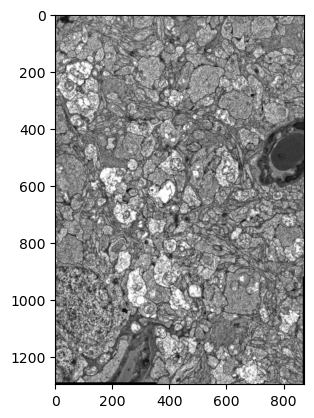

In [291]:
mosaic = Mosaic(cell_image_paths)
mosaic.build_mosaic()
mosaic.plot_mosaic()

# 5) Extra Credit (up to 25 points) – Neural Networks for Image Translation
Design, implement, train, and test a neural network that estimates the relative offset (shift) between pairs of images.  

Model Architecture for Image Registration looks like the one below.

Neural network design

For the backbone, you can use the Pretrained model ResNet18 already provided in the Pytroch models. You can use other pre-trained models as well, like Alexnet, ResNet34, ResNet50, etc. Refer to the link below:-

https://pytorch.org/vision/stable/models.html

These models are trained for classification on ImageNet Dataset, but pre-trained trained layers of these networks provide a good starting point for the network for different applications such as instance segmentation, registration, etc.

a)  You have to use features that are observed at layer3 in the Resnet18 model for concatenation. (Note:- You don't have to use 2 backbones, a single backbone should work)

b)  Regression network Architecture is similar to the Classification network shared in the PyTorch tutorial; instead of 10 output for MNIST, the output will be just 2. However, the model will require more convolutions, max pool layers, and fully connected layers. You will also need to use BatchNorm2d in the Regression Network.

Code Given:-
extract_patched_training.py:- Creates the training set extract_patched_testing.py:- Creates the testing set utils.py:- DatasetLoader for the exercise.  Find the code here Download here.

The structure of the code will be similar to the denoising project. There will be changes in the training and testing loops to handle 4 inputs(2 images, x-shift, and y-shift) rather than 2. The model will be given 2 images compared to 1 in the denoising problem.

For visualizations, whether the predicted x and y shifts are correct or not, you will need to use the warp function provided in the skimage library or resample images with the shift in coordinates.



In [455]:
import sys
sys.path.append('../src/utils')
from utils import RegistrationDatasetLoader
from torch.utils.data import DataLoader

In [456]:
train_data = RegistrationDatasetLoader(csv_file='../src/utils/TrainingDatasetClassification.csv', root_dir_input='../src/utils', root_dir_ref='../src/utils')
test_data = RegistrationDatasetLoader(csv_file='../src/utils/TestingDatasetClassification.csv', root_dir_input='../src/utils', root_dir_ref='../src/utils')

loaders = {
    'train' : DataLoader(train_data, batch_size=1, shuffle=True), 
    'test' : test_data
}
len(train_data), len(test_data), train_data[0].keys()

(9483, 1530, dict_keys(['ref_image', 'inputImage', 'x-shift', 'y-shift']))

In [457]:
train_data[0]['ref_image'].shape

torch.Size([3, 256, 256])

In [458]:
from torchvision.models import resnet18, ResNet18_Weights

In [459]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

class ImageRegistration(nn.Module):
    def __init__(self):
        super(ImageRegistration, self).__init__()
        
        # Load pre-trained ResNet18 model
        self.resnet18 = models.resnet18(pretrained=True)
        
        # Remove the fully connected layers at the end
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-2])
        
        # Set the model to evaluation mode
        self.resnet18.eval()
        
        # Disable gradient computation for the ResNet18 parameters
        for param in self.resnet18.parameters():
            param.requires_grad = False

        self.end_conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1024,              
                out_channels=64,            
                kernel_size=2,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),
            nn.BatchNorm2d(64),                        
            nn.MaxPool2d(kernel_size=2),  
            
        )
        self.end_conv2 = nn.Sequential(         
                nn.Conv2d(64, 32, 5, 1, 2),     
                nn.ReLU(),   
                nn.BatchNorm2d(32),                    
                nn.MaxPool2d(2),                
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2),
            nn.Sigmoid()
        )

    def forward(self, image1, image2):
        # Process the first image (input)
        features1 = self.resnet18(image1)
        
        # Process the second image (reference)
        features2 = self.resnet18(image2)
        
        # Concatenate the output features along the channel dimension
        concatenated_features = torch.cat((features1, features2), dim=1)

        # Build the 
        conv1 = self.end_conv1(concatenated_features)
        conv2 = self.end_conv2(conv1)
        fc = self.fc(conv2)
        
        return fc


image1 = torch.randn(1, 3,256,256)
image2 = torch.randn(1, 3,256,256)

model = ImageRegistration().to('cuda' if torch.cuda.is_available else 'cpu')

# Forward pass
output = model(image1, image2)

print("Output shape:", output.shape)


/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/terrycox/.conda/envs/img_proc_proj0/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AssertionError: Torch not compiled with CUDA enabled

In [460]:
loss_func = nn.CrossEntropyLoss() 

from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

# help from https://www.kaggle.com/code/ggsri123/implementing-resnet18-for-image-classification
def train_batch(x1, x2, y, model, opt, loss_fn):
    model.train()
    prediction = model(x1, x2)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x1, x2, y, model):
    model.eval()
    prediction = model(x1,x2)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

train_losses, train_accuracies = [], []
val_accuracies = []

epochs = 10

print("All losses and accuracies are for each epoch")
for epoch in range(epochs):
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(loaders['train'])):
        x1 = batch['inputImage']
        x2 = batch['ref_image']
        y = torch.stack([batch['x-shift'], batch['y-shift']]).T.float()

        batch_loss = train_batch(x1, x2, y, model, optimizer, loss_func)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(loaders['train'])):
        x1 = batch['inputImage']
        x2 = batch['ref_image']
        y = torch.stack([batch['x-shift'], batch['y-shift']]).T.float()

        is_correct = accuracy(x1, x2, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(loaders['test'])):
        x1 = batch['inputImage']
        x2 = batch['ref_image']
        y = torch.stack([batch['x-shift'], batch['y-shift']]).T.float()

        val_is_correct = accuracy(x1, x2, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(epochs)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with ResNet18 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()



All losses and accuracies are for each epoch


KeyboardInterrupt: 

In [ ]:
def test():
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for vals in loaders['test']:
            x1 = vals['inputImage']
            x2 = vals['ref_image']
            labels = torch.Tensor[vals['x-shift'], vals['y-shift']]
            
            test_output, last_layer = model(x1, x2)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the test images: %.2f' % accuracy)
    pass
test()

# Save
torch.save(model.state_dict(), '../image_registration_state_dict.pt')